The task of recovering a high resolution (HR) image from its low resolution counterpart is commonly referred to as Single Image Super Resolution (SISR). 

The model implemented here is ESPCN ([Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network](https://arxiv.org/abs/1609.05158)) and we are going to use TensorFlow Lite to run inference on the trained model.

## Setup

We are going to need to do some color space transformation, so let's install OpenCV first.

In [1]:
!pip install opencv-python

Import dependencies.

In [2]:
import tensorflow as tf
import tarfile
import datetime
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import Conv2D, Input, Lambda, Activation
from tensorflow.python.keras.models import Model
from os.path import exists, join, basename
from os import makedirs, remove, path
from six.moves import urllib

Set some parameters and download BSD300 dataset.

In [3]:
SCALE = 3
LR_SIZE = 100
# Make sure HR_SIZE is smaller than 300 since some images in the dataset have height/width < 300
HR_SIZE = LR_SIZE * SCALE

BATCH_SIZE = 100

def download_dataset(file, target_dir="dataset", extract=True):
    if not exists(join(target_dir, "BSDS300/images")):
        source_url = "http://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz"
        target_dir = path.abspath(target_dir)
        tf.keras.utils.get_file(file, source_url, cache_subdir=target_dir, extract=extract)

download_dataset('BSDS300-images.tgz')

TRAIN_IMAGES = "dataset/BSDS300/images/train/*.jpg"  
TEST_IMAGES = "dataset/BSDS300/images/test/*.jpg"

22216704/22211847 [==============================] - 7s 0us/step


ESPCN implements a simple network with 3 convolutional layers and 1 pixel shuffle layer on the Y channel (luminance) in the YCbCr color space. Cb and Cr channels are upsampled using bicubic method. We can prepare our training and test datasets as the following.

In [4]:
def extract_luminance(path):
    img = cv2.imread(path.numpy().decode('UTF8'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    # Extract luminance
    img_y = img[:, :, 0:1]
    return img_y

def load_image(img_path):
    [hr_img,] = tf.py_function(extract_luminance, [img_path], [tf.float32])
    hr_img = tf.convert_to_tensor(hr_img)
    hr_img = tf.image.random_crop(hr_img, [HR_SIZE, HR_SIZE, 1])
    hr_img = tf.cast(hr_img, tf.float32)
    hr_img = hr_img / 255.
    lr_img = tf.image.resize(hr_img, [HR_SIZE//SCALE, HR_SIZE//SCALE], tf.image.ResizeMethod.BICUBIC)
    return lr_img, hr_img

training_dataset = tf.data.Dataset.list_files(TRAIN_IMAGES) \
                   .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
                   .batch(BATCH_SIZE) \
                   .prefetch(tf.data.experimental.AUTOTUNE) \
                   .shuffle(buffer_size = 200) 

test_dataset = tf.data.Dataset.list_files(TEST_IMAGES) \
                   .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
                   .batch(BATCH_SIZE) \
                   .prefetch(tf.data.experimental.AUTOTUNE)

## Build the model

In [5]:
# Helper function to wrap depth_to_space op (pixel shuffle) in a Lambda layer
def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)

input = Input(shape=(LR_SIZE, LR_SIZE, 1))
x = Conv2D(64, [5, 5], padding='same', activation='relu')(input)
x = Conv2D(32, [3, 3], padding='same', activation='relu')(x)
x = Conv2D(SCALE**2, [3, 3], padding='same')(x)
x = Lambda(pixel_shuffle(scale=SCALE))(x)
x = Activation('tanh')(x)
model = Model(input, x, name="ESPCN")

logdir = "./logdir/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=tf.keras.losses.MSE)

model.summary()

Model: "ESPCN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 64)      1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      18464     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 9)       2601      
_________________________________________________________________
lambda (Lambda)              (None, 300, 300, 1)       0         
_________________________________________________________________
activation (Activation)      (None, 300, 300, 1)       0         
Total params: 22,729
Trainable params: 22,729
Non-trainable params: 0
_________________________________________________________

## Train and export the model

In [6]:
model.fit(training_dataset,epochs= 700,validation_data=test_dataset,
                    callbacks = [tensorboard_callback],workers = 4)

model.save("export")

Epoch 1/700
2/2 [==============================] - 35s 2s/step - loss: 0.2949 - val_loss: 0.2945
Epoch 2/700
2/2 [==============================] - 1s 521ms/step - loss: 0.2832 - val_loss: 0.2759
Epoch 3/700
2/2 [==============================] - 1s 465ms/step - loss: 0.2728 - val_loss: 0.2673
Epoch 4/700
2/2 [==============================] - 1s 459ms/step - loss: 0.2639 - val_loss: 0.2542
Epoch 5/700
2/2 [==============================] - 1s 484ms/step - loss: 0.2543 - val_loss: 0.2456
Epoch 6/700
2/2 [==============================] - 1s 476ms/step - loss: 0.2431 - val_loss: 0.2406
Epoch 7/700
2/2 [==============================] - 1s 465ms/step - loss: 0.2343 - val_loss: 0.2300
Epoch 8/700
2/2 [==============================] - 1s 466ms/step - loss: 0.2287 - val_loss: 0.2185
Epoch 9/700
2/2 [==============================] - 1s 467ms/step - loss: 0.2179 - val_loss: 0.2144
Epoch 10/700
2/2 [==============================] - 1s 482ms/step - loss: 0.2109 - val_loss: 0.2030
Epoch 11/70

## Super resolve a test low resolution image using TensorFlow Lite.

In [7]:
def load_test_image(img_path):
    hr = cv2.imread(img_path)
    hr = cv2.cvtColor(hr, cv2.COLOR_BGR2YCrCb)
    hr = tf.image.crop_to_bounding_box(hr, 0, 0, HR_SIZE, HR_SIZE)
    lr = tf.image.resize(hr, [HR_SIZE//SCALE, HR_SIZE//SCALE])
    lr = tf.cast(lr, tf.uint8)
    return lr, hr

def super_resolve(original_img_path):
    # lr - low resolution image
    # hr - high resolution image (cropped from original)
    # sr - super resolved image from lr
    lr, hr = load_test_image(original_img_path)
    lr_ycrcb = lr.numpy().copy()    
    lr = cv2.cvtColor(lr.numpy(), cv2.COLOR_YCrCb2RGB)
    hr = cv2.cvtColor(hr.numpy(), cv2.COLOR_YCrCb2RGB)   
    lr_ycrcb = tf.cast(lr_ycrcb, tf.float32)
    lr_y = lr_ycrcb[:, :, 0:1] / 255.
    lr_cr = lr_ycrcb[:, :, 1:2]
    lr_cb = lr_ycrcb[:, :, 2:3]
    lr_y = tf.expand_dims(lr_y, axis=0)
    
    # Use TFLite to super resolve luminance
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], lr_y)
    interpreter.invoke()
    sr_y = interpreter.get_tensor(output_details[0]['index'])
    open("ESPCN.tflite", 'wb').write(tflite_model)
    
    # Transform super resolved image back into RGB color space
    sr_y = sr_y * 255
    sr_cr = tf.image.resize(lr_cr, [HR_SIZE, HR_SIZE], tf.image.ResizeMethod.BICUBIC)
    sr_cb = tf.image.resize(lr_cb, [HR_SIZE, HR_SIZE], tf.image.ResizeMethod.BICUBIC)
    sr = tf.concat([sr_y[0], sr_cr, sr_cb], axis=2)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    sr = cv2.cvtColor(sr.numpy(), cv2.COLOR_YCrCb2RGB)
    return lr, sr, hr

# test_img_path = "dataset/BSDS300/images/test/170057.jpg"
test_img_path = "dataset/BSDS300/images/test/302008.jpg"
lr, sr, hr = super_resolve(test_img_path)

INFO:tensorflow:Assets written to: /tmp/tmp94zdjo4t/assets


## Visualize the result

PSNR ([Peak Signal-to-Noise Ratio](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio)) is a commonly used metric to measure the image recovery quality.

PSNR of super resolved image: %f 29.244078


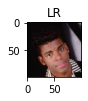

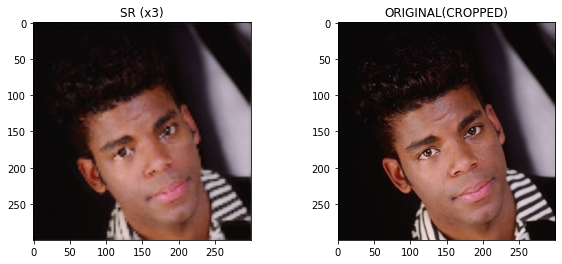

In [8]:
print("PSNR of super resolved image: %f", tf.image.psnr(sr, hr, 255).numpy())  

plt.figure(figsize = (1, 1))
plt.title('LR')
plt.imshow(lr);


plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)        
plt.title(f'SR (x{SCALE})')
plt.imshow(sr);


plt.subplot(1, 2, 2)   
plt.title('ORIGINAL(CROPPED)')
plt.imshow(hr);

## Check the PSNR for the entire test set

In [9]:
import os
test_directory = 'dataset/BSDS300/images/test/'
psnr_list = []
for file in os.listdir(test_directory):
    print(file)
    lr, sr, hr = super_resolve(os.path.join(test_directory + file))
    psnr = tf.image.psnr(sr, hr, 255).numpy()
    print('PSNR:', psnr)
    psnr_list.append(psnr)
    
print('Average PSNR for the test set: ', np.mean(psnr_list))

167083.jpg
INFO:tensorflow:Assets written to: /tmp/tmpks1d_aai/assets


INFO:tensorflow:Assets written to: /tmp/tmpks1d_aai/assets


PSNR: 16.933733
21077.jpg
INFO:tensorflow:Assets written to: /tmp/tmp7swhhf14/assets


INFO:tensorflow:Assets written to: /tmp/tmp7swhhf14/assets


PSNR: 23.1514
24077.jpg
INFO:tensorflow:Assets written to: /tmp/tmphziat81f/assets


INFO:tensorflow:Assets written to: /tmp/tmphziat81f/assets


PSNR: 20.70185
102061.jpg
INFO:tensorflow:Assets written to: /tmp/tmpv0zrd7a_/assets


INFO:tensorflow:Assets written to: /tmp/tmpv0zrd7a_/assets


PSNR: 21.368103
12084.jpg
INFO:tensorflow:Assets written to: /tmp/tmp_3isponx/assets


INFO:tensorflow:Assets written to: /tmp/tmp_3isponx/assets


PSNR: 25.85876
76053.jpg
INFO:tensorflow:Assets written to: /tmp/tmpdyoayk3f/assets


INFO:tensorflow:Assets written to: /tmp/tmpdyoayk3f/assets


PSNR: 26.634823
37073.jpg
INFO:tensorflow:Assets written to: /tmp/tmpe3y_tvp8/assets


INFO:tensorflow:Assets written to: /tmp/tmpe3y_tvp8/assets


PSNR: 26.736624
134035.jpg
INFO:tensorflow:Assets written to: /tmp/tmp4y6vpeo8/assets


INFO:tensorflow:Assets written to: /tmp/tmp4y6vpeo8/assets


PSNR: 20.541302
296059.jpg
INFO:tensorflow:Assets written to: /tmp/tmpr37r5eup/assets


INFO:tensorflow:Assets written to: /tmp/tmpr37r5eup/assets


PSNR: 27.978172
376043.jpg
INFO:tensorflow:Assets written to: /tmp/tmp_18082bi/assets


INFO:tensorflow:Assets written to: /tmp/tmp_18082bi/assets


PSNR: 22.317131
351093.jpg
INFO:tensorflow:Assets written to: /tmp/tmpatyth6eo/assets


INFO:tensorflow:Assets written to: /tmp/tmpatyth6eo/assets


PSNR: 19.405033
108082.jpg
INFO:tensorflow:Assets written to: /tmp/tmp65a3ytut/assets


INFO:tensorflow:Assets written to: /tmp/tmp65a3ytut/assets


PSNR: 23.893274
208001.jpg
INFO:tensorflow:Assets written to: /tmp/tmpk6vmhx4h/assets


INFO:tensorflow:Assets written to: /tmp/tmpk6vmhx4h/assets


PSNR: 26.038584
126007.jpg
INFO:tensorflow:Assets written to: /tmp/tmphuyxbqpq/assets


INFO:tensorflow:Assets written to: /tmp/tmphuyxbqpq/assets


PSNR: 26.989075
42012.jpg
INFO:tensorflow:Assets written to: /tmp/tmp9qnbd8ot/assets


INFO:tensorflow:Assets written to: /tmp/tmp9qnbd8ot/assets


PSNR: 28.42729
197017.jpg
INFO:tensorflow:Assets written to: /tmp/tmpawon60ay/assets


INFO:tensorflow:Assets written to: /tmp/tmpawon60ay/assets


PSNR: 25.238428
38092.jpg
INFO:tensorflow:Assets written to: /tmp/tmp3xsk7vg2/assets


INFO:tensorflow:Assets written to: /tmp/tmp3xsk7vg2/assets


PSNR: 23.324335
108005.jpg
INFO:tensorflow:Assets written to: /tmp/tmpzkghnmni/assets


INFO:tensorflow:Assets written to: /tmp/tmpzkghnmni/assets


PSNR: 23.407682
101085.jpg
INFO:tensorflow:Assets written to: /tmp/tmpook3r_mv/assets


INFO:tensorflow:Assets written to: /tmp/tmpook3r_mv/assets


PSNR: 22.247463
42049.jpg
INFO:tensorflow:Assets written to: /tmp/tmpwn0b32gb/assets


INFO:tensorflow:Assets written to: /tmp/tmpwn0b32gb/assets


PSNR: 25.509016
97033.jpg
INFO:tensorflow:Assets written to: /tmp/tmpx2guyxje/assets


INFO:tensorflow:Assets written to: /tmp/tmpx2guyxje/assets


PSNR: 21.672634
62096.jpg
INFO:tensorflow:Assets written to: /tmp/tmphi9hnk2h/assets


INFO:tensorflow:Assets written to: /tmp/tmphi9hnk2h/assets


PSNR: 21.16928
66053.jpg
INFO:tensorflow:Assets written to: /tmp/tmpzkyt24z3/assets


INFO:tensorflow:Assets written to: /tmp/tmpzkyt24z3/assets


PSNR: 25.189337
65033.jpg
INFO:tensorflow:Assets written to: /tmp/tmptj4aae3j/assets


INFO:tensorflow:Assets written to: /tmp/tmptj4aae3j/assets


PSNR: 22.272123
3096.jpg
INFO:tensorflow:Assets written to: /tmp/tmpsygcqbca/assets


INFO:tensorflow:Assets written to: /tmp/tmpsygcqbca/assets


PSNR: 35.42349
241004.jpg
INFO:tensorflow:Assets written to: /tmp/tmp1210bfdl/assets


INFO:tensorflow:Assets written to: /tmp/tmp1210bfdl/assets


PSNR: 26.230082
58060.jpg
INFO:tensorflow:Assets written to: /tmp/tmpkrj2f1f8/assets


INFO:tensorflow:Assets written to: /tmp/tmpkrj2f1f8/assets


PSNR: 18.230953
285079.jpg
INFO:tensorflow:Assets written to: /tmp/tmpdmepyzxi/assets


INFO:tensorflow:Assets written to: /tmp/tmpdmepyzxi/assets


PSNR: 22.22082
85048.jpg
INFO:tensorflow:Assets written to: /tmp/tmpktysdj30/assets


INFO:tensorflow:Assets written to: /tmp/tmpktysdj30/assets


PSNR: 22.66865
86068.jpg
INFO:tensorflow:Assets written to: /tmp/tmpff3a60fp/assets


INFO:tensorflow:Assets written to: /tmp/tmpff3a60fp/assets


PSNR: 24.142645
55073.jpg
INFO:tensorflow:Assets written to: /tmp/tmpnq1wnwnj/assets


INFO:tensorflow:Assets written to: /tmp/tmpnq1wnwnj/assets


PSNR: 18.962376
45096.jpg
INFO:tensorflow:Assets written to: /tmp/tmptm9vdexi/assets


INFO:tensorflow:Assets written to: /tmp/tmptm9vdexi/assets


PSNR: 30.380177
260058.jpg
INFO:tensorflow:Assets written to: /tmp/tmp7qok7929/assets


INFO:tensorflow:Assets written to: /tmp/tmp7qok7929/assets


PSNR: 29.934456
16077.jpg
INFO:tensorflow:Assets written to: /tmp/tmpmc77ded4/assets


INFO:tensorflow:Assets written to: /tmp/tmpmc77ded4/assets


PSNR: 24.077496
216081.jpg
INFO:tensorflow:Assets written to: /tmp/tmp11bkdvj9/assets


INFO:tensorflow:Assets written to: /tmp/tmp11bkdvj9/assets


PSNR: 22.754831
163085.jpg
INFO:tensorflow:Assets written to: /tmp/tmpgq9j2okq/assets


INFO:tensorflow:Assets written to: /tmp/tmpgq9j2okq/assets


PSNR: 27.040512
304074.jpg
INFO:tensorflow:Assets written to: /tmp/tmpyytagzjh/assets


INFO:tensorflow:Assets written to: /tmp/tmpyytagzjh/assets


PSNR: 23.421858
69040.jpg
INFO:tensorflow:Assets written to: /tmp/tmpegdrsr2j/assets


INFO:tensorflow:Assets written to: /tmp/tmpegdrsr2j/assets


PSNR: 22.878464
41033.jpg
INFO:tensorflow:Assets written to: /tmp/tmpbrt8x8ux/assets


INFO:tensorflow:Assets written to: /tmp/tmpbrt8x8ux/assets


PSNR: 28.98858
145086.jpg
INFO:tensorflow:Assets written to: /tmp/tmp23gqpakb/assets


INFO:tensorflow:Assets written to: /tmp/tmp23gqpakb/assets


PSNR: 22.037645
148089.jpg
INFO:tensorflow:Assets written to: /tmp/tmpq9vzozzs/assets


INFO:tensorflow:Assets written to: /tmp/tmpq9vzozzs/assets


PSNR: 20.5953
306005.jpg
INFO:tensorflow:Assets written to: /tmp/tmpssnyetvl/assets


INFO:tensorflow:Assets written to: /tmp/tmpssnyetvl/assets


PSNR: 24.445156
109053.jpg
INFO:tensorflow:Assets written to: /tmp/tmphlokluuf/assets


INFO:tensorflow:Assets written to: /tmp/tmphlokluuf/assets


PSNR: 28.234522
148026.jpg
INFO:tensorflow:Assets written to: /tmp/tmpyhld5bi5/assets


INFO:tensorflow:Assets written to: /tmp/tmpyhld5bi5/assets


PSNR: 18.855219
69020.jpg
INFO:tensorflow:Assets written to: /tmp/tmpidezaysm/assets


INFO:tensorflow:Assets written to: /tmp/tmpidezaysm/assets


PSNR: 24.852291
253055.jpg
INFO:tensorflow:Assets written to: /tmp/tmpjczlfoup/assets


INFO:tensorflow:Assets written to: /tmp/tmpjczlfoup/assets


PSNR: 24.627172
302008.jpg
INFO:tensorflow:Assets written to: /tmp/tmp_d6e7ttq/assets


INFO:tensorflow:Assets written to: /tmp/tmp_d6e7ttq/assets


PSNR: 29.244078
300091.jpg
INFO:tensorflow:Assets written to: /tmp/tmp4so18eyz/assets


INFO:tensorflow:Assets written to: /tmp/tmp4so18eyz/assets


PSNR: 26.23752
219090.jpg
INFO:tensorflow:Assets written to: /tmp/tmplq92r2s_/assets


INFO:tensorflow:Assets written to: /tmp/tmplq92r2s_/assets


PSNR: 23.63265
33039.jpg
INFO:tensorflow:Assets written to: /tmp/tmp4kok9k7x/assets


INFO:tensorflow:Assets written to: /tmp/tmp4kok9k7x/assets


PSNR: 18.103525
295087.jpg
INFO:tensorflow:Assets written to: /tmp/tmpz083ccpr/assets


INFO:tensorflow:Assets written to: /tmp/tmpz083ccpr/assets


PSNR: 25.0486
101087.jpg
INFO:tensorflow:Assets written to: /tmp/tmpk3nqrppm/assets


INFO:tensorflow:Assets written to: /tmp/tmpk3nqrppm/assets


PSNR: 21.516272
291000.jpg
INFO:tensorflow:Assets written to: /tmp/tmpspwbjfp5/assets


INFO:tensorflow:Assets written to: /tmp/tmpspwbjfp5/assets


PSNR: 19.025757
196073.jpg
INFO:tensorflow:Assets written to: /tmp/tmpzb675tzl/assets


INFO:tensorflow:Assets written to: /tmp/tmpzb675tzl/assets


PSNR: 25.218624
182053.jpg
INFO:tensorflow:Assets written to: /tmp/tmp3jb3bm21/assets


INFO:tensorflow:Assets written to: /tmp/tmp3jb3bm21/assets


PSNR: 21.281696
157055.jpg
INFO:tensorflow:Assets written to: /tmp/tmpc4b76nau/assets


INFO:tensorflow:Assets written to: /tmp/tmpc4b76nau/assets


PSNR: 23.06843
241048.jpg
INFO:tensorflow:Assets written to: /tmp/tmpmzf6bbye/assets


INFO:tensorflow:Assets written to: /tmp/tmpmzf6bbye/assets


PSNR: 21.735918
14037.jpg
INFO:tensorflow:Assets written to: /tmp/tmpa4de2gmt/assets


INFO:tensorflow:Assets written to: /tmp/tmpa4de2gmt/assets


PSNR: 29.66398
86016.jpg
INFO:tensorflow:Assets written to: /tmp/tmp8xcxb1qz/assets


INFO:tensorflow:Assets written to: /tmp/tmp8xcxb1qz/assets


PSNR: 20.133091
170057.jpg
INFO:tensorflow:Assets written to: /tmp/tmpa9oqn83x/assets


INFO:tensorflow:Assets written to: /tmp/tmpa9oqn83x/assets


PSNR: 27.783445
103070.jpg
INFO:tensorflow:Assets written to: /tmp/tmpso8yp6cp/assets


INFO:tensorflow:Assets written to: /tmp/tmpso8yp6cp/assets


PSNR: 26.9418
78004.jpg
INFO:tensorflow:Assets written to: /tmp/tmpri6qok79/assets


INFO:tensorflow:Assets written to: /tmp/tmpri6qok79/assets


PSNR: 22.355639
167062.jpg
INFO:tensorflow:Assets written to: /tmp/tmp660nvtxz/assets


INFO:tensorflow:Assets written to: /tmp/tmp660nvtxz/assets


PSNR: 23.500963
105025.jpg
INFO:tensorflow:Assets written to: /tmp/tmpgcy7xh_1/assets


INFO:tensorflow:Assets written to: /tmp/tmpgcy7xh_1/assets


PSNR: 22.630348
43074.jpg
INFO:tensorflow:Assets written to: /tmp/tmpj7t9faem/assets


INFO:tensorflow:Assets written to: /tmp/tmpj7t9faem/assets


PSNR: 26.95098
159008.jpg
INFO:tensorflow:Assets written to: /tmp/tmp8tvsa5kf/assets


INFO:tensorflow:Assets written to: /tmp/tmp8tvsa5kf/assets


PSNR: 25.457962
147091.jpg
INFO:tensorflow:Assets written to: /tmp/tmpp4b0065t/assets


INFO:tensorflow:Assets written to: /tmp/tmpp4b0065t/assets


PSNR: 22.817081
210088.jpg
INFO:tensorflow:Assets written to: /tmp/tmplf1ler97/assets


INFO:tensorflow:Assets written to: /tmp/tmplf1ler97/assets


PSNR: 27.845224
108070.jpg
INFO:tensorflow:Assets written to: /tmp/tmptlvrlc1y/assets


INFO:tensorflow:Assets written to: /tmp/tmptlvrlc1y/assets


PSNR: 21.960947
299086.jpg
INFO:tensorflow:Assets written to: /tmp/tmptco_0iir/assets


INFO:tensorflow:Assets written to: /tmp/tmptco_0iir/assets


PSNR: 31.425722
143090.jpg
INFO:tensorflow:Assets written to: /tmp/tmpmxb_feep/assets


INFO:tensorflow:Assets written to: /tmp/tmpmxb_feep/assets


PSNR: 29.516665
119082.jpg
INFO:tensorflow:Assets written to: /tmp/tmps68oyszn/assets


INFO:tensorflow:Assets written to: /tmp/tmps68oyszn/assets


PSNR: 20.625036
130026.jpg
INFO:tensorflow:Assets written to: /tmp/tmpmc9mg5n3/assets


INFO:tensorflow:Assets written to: /tmp/tmpmc9mg5n3/assets


PSNR: 22.442017
223061.jpg
INFO:tensorflow:Assets written to: /tmp/tmpgel8u95z/assets


INFO:tensorflow:Assets written to: /tmp/tmpgel8u95z/assets


PSNR: 22.028711
236037.jpg
INFO:tensorflow:Assets written to: /tmp/tmpw2wvp95z/assets


INFO:tensorflow:Assets written to: /tmp/tmpw2wvp95z/assets


PSNR: 22.705029
156065.jpg
INFO:tensorflow:Assets written to: /tmp/tmpu0gq56yk/assets


INFO:tensorflow:Assets written to: /tmp/tmpu0gq56yk/assets


PSNR: 23.62076
253027.jpg
INFO:tensorflow:Assets written to: /tmp/tmp_j7jp9rk/assets


INFO:tensorflow:Assets written to: /tmp/tmp_j7jp9rk/assets


PSNR: 19.075321
89072.jpg
INFO:tensorflow:Assets written to: /tmp/tmpiog9e516/assets


INFO:tensorflow:Assets written to: /tmp/tmpiog9e516/assets


PSNR: 23.753815
87046.jpg
INFO:tensorflow:Assets written to: /tmp/tmpoduslgq9/assets


INFO:tensorflow:Assets written to: /tmp/tmpoduslgq9/assets


PSNR: 23.481613
160068.jpg
INFO:tensorflow:Assets written to: /tmp/tmpydgwwiki/assets


INFO:tensorflow:Assets written to: /tmp/tmpydgwwiki/assets


PSNR: 23.540497
86000.jpg
INFO:tensorflow:Assets written to: /tmp/tmpy6d_dlt6/assets


INFO:tensorflow:Assets written to: /tmp/tmpy6d_dlt6/assets


PSNR: 22.001896
8023.jpg
INFO:tensorflow:Assets written to: /tmp/tmp1zqmgxh1/assets


INFO:tensorflow:Assets written to: /tmp/tmp1zqmgxh1/assets


PSNR: 26.584234
41069.jpg
INFO:tensorflow:Assets written to: /tmp/tmp0emm7ye1/assets


INFO:tensorflow:Assets written to: /tmp/tmp0emm7ye1/assets


PSNR: 22.180597
296007.jpg
INFO:tensorflow:Assets written to: /tmp/tmp5jglfajp/assets


INFO:tensorflow:Assets written to: /tmp/tmp5jglfajp/assets


PSNR: 29.437372
229036.jpg
INFO:tensorflow:Assets written to: /tmp/tmp0tme_49w/assets


INFO:tensorflow:Assets written to: /tmp/tmp0tme_49w/assets


PSNR: 20.308784
69015.jpg
INFO:tensorflow:Assets written to: /tmp/tmpepj1jels/assets


INFO:tensorflow:Assets written to: /tmp/tmpepj1jels/assets


PSNR: 26.78174
123074.jpg
INFO:tensorflow:Assets written to: /tmp/tmpphln5z1j/assets


INFO:tensorflow:Assets written to: /tmp/tmpphln5z1j/assets


PSNR: 26.974154
106024.jpg
INFO:tensorflow:Assets written to: /tmp/tmphz_2pdri/assets


INFO:tensorflow:Assets written to: /tmp/tmphz_2pdri/assets


PSNR: 26.149118
54082.jpg
INFO:tensorflow:Assets written to: /tmp/tmpkdpc9yal/assets


INFO:tensorflow:Assets written to: /tmp/tmpkdpc9yal/assets


PSNR: 25.823256
271035.jpg
INFO:tensorflow:Assets written to: /tmp/tmpp_ukvmiz/assets


INFO:tensorflow:Assets written to: /tmp/tmpp_ukvmiz/assets


PSNR: 23.73665
227092.jpg
INFO:tensorflow:Assets written to: /tmp/tmpkq6od8gd/assets


INFO:tensorflow:Assets written to: /tmp/tmpkq6od8gd/assets


PSNR: 29.815823
175032.jpg
INFO:tensorflow:Assets written to: /tmp/tmpqiytdzf4/assets


INFO:tensorflow:Assets written to: /tmp/tmpqiytdzf4/assets


PSNR: 18.525143
19021.jpg
INFO:tensorflow:Assets written to: /tmp/tmp7ug4tl1f/assets


INFO:tensorflow:Assets written to: /tmp/tmp7ug4tl1f/assets


PSNR: 24.353693
361010.jpg
INFO:tensorflow:Assets written to: /tmp/tmpiccae2wy/assets


INFO:tensorflow:Assets written to: /tmp/tmpiccae2wy/assets


PSNR: 25.225317
38082.jpg
INFO:tensorflow:Assets written to: /tmp/tmpqc_dd6xy/assets


INFO:tensorflow:Assets written to: /tmp/tmpqc_dd6xy/assets


PSNR: 24.707022
175043.jpg
INFO:tensorflow:Assets written to: /tmp/tmpgb4n6em5/assets


INFO:tensorflow:Assets written to: /tmp/tmpgb4n6em5/assets


PSNR: 23.02653
220075.jpg
INFO:tensorflow:Assets written to: /tmp/tmp6o8l4ko6/assets


INFO:tensorflow:Assets written to: /tmp/tmp6o8l4ko6/assets


PSNR: 25.44269
304034.jpg
INFO:tensorflow:Assets written to: /tmp/tmpbdqkqhqi/assets


INFO:tensorflow:Assets written to: /tmp/tmpbdqkqhqi/assets


PSNR: 22.98514
189080.jpg
INFO:tensorflow:Assets written to: /tmp/tmpw5eqs8hg/assets


INFO:tensorflow:Assets written to: /tmp/tmpw5eqs8hg/assets


PSNR: 27.471394
385039.jpg
INFO:tensorflow:Assets written to: /tmp/tmperbtd4r4/assets


INFO:tensorflow:Assets written to: /tmp/tmperbtd4r4/assets


PSNR: 20.404716
Average PSNR for the test set:  24.143133
